# Data validation
This is a mostly manual section, where we check data validity and inconsistencies. Also, it is important for the data to be resilient to bugs.

crim
per capita crime rate by town.

zn
proportion of residential land zoned for lots over 25,000 sq.ft.

indus
proportion of non-retail business acres per town.

chas
Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

nox
nitrogen oxides concentration (parts per 10 million).

rm
average number of rooms per dwelling.

age
proportion of owner-occupied units built prior to 1940.

dis
weighted mean of distances to five Boston employment centres.

rad
index of accessibility to radial highways.

tax
full-value property-tax rate per \$10,000.

ptratio
pupil-teacher ratio by town.

black
1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.

lstat
lower status of the population (percent).

medv
median value of owner-occupied homes in \$1000s.

Source
Harrison, D. and Rubinfeld, D.L. (1978) Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.

Belsley D.A., Kuh, E. and Welsch, R.E. (1980) Regression Diagnostics. Identifying Influential Data and Sources of Collinearity. New York: Wiley.

In [47]:
import os
import pickle as pkl
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# %matplotlib inline
warnings.filterwarnings('ignore')

# set sandbox_mode boolean for image building
* if sandbox_mode == True: faster to run, but images won't be generated

In [74]:
sandbox_mode = False

# define functions

In [49]:
# get numerical columns
def get_numerical_mask(df):
    type_mask = []
    for i in df.dtypes:
        if str(i).startswith('float') or str(i).startswith('int'): # or str(i).startswith('bool')
            type_mask.append(True)
        else: type_mask.append(False)
    num_cols = list(np.array(df.columns)[type_mask])
    other_cols = list(np.array(df.columns)[[not elem for elem in type_mask]])
    
    return num_cols, other_cols

# build boxplots
def build_boxplots(df, file):
    
    plt.close()
    
    cols = df.columns
    fig, axes = plt.subplots(1,len(cols),figsize=(15,5))

    for ax,col in zip(axes, cols):
        sns.boxplot(y = col, data = df[cols], ax = ax, width=.1)
    plt.tight_layout()
    plt.plot()
    
    # save file
    file = '01boxplot_'+file+'.jpg'
    plt.savefig(os.path.join(reports,file), bbox_inches = "tight")

# Define paths and capture data

In [50]:
from sklearn import datasets    
boston = datasets.load_boston()
data = pd.DataFrame(boston.data, columns = boston.feature_names)
data['y'] = boston.target

In [51]:
print('shape of data:', data.shape)
data.head()

shape of data: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# standardize data

#### columns

In [52]:
data.rename({c: c.lower() for c in data.columns}, axis=1, inplace=True)
# data.rename({'medv': 'y'}, axis=1, inplace=True)

#### strip values of categorical

In [53]:
for cat in data.columns:
    if data[cat].dtypes == 'object':
        data[cat] = data[cat].apply(lambda x: x.strip().lower())

# check duplicates for main data

# set index

In [54]:
# data.set_index('id', inplace=True)
data.index.rename('id', inplace=True)

# build new variables

In [55]:
# todo

# drop unused columns

# boolean features to float (0,1)

# fix non-categorical types

# evaluate categorical features

In [56]:
categories_dict = {}
for cat in data.columns:
    if data[cat].dtypes == 'object':
        categories_dict[cat] = list(data[cat].unique())
        n_categories = data[cat].unique().size
        print("number of categories for variable '{}': {} ".format(cat, n_categories))

# distribution of categorical vars
By doing this checkup, some details come to our attention. The biggest one is that some categories are defined with an question mark "?". It is tempting to consider it missing value, but that would be a hasty decision because further analysis (mainly inquiring the data provider) should be previously done.

The main reason to avoid treating those values is that we can't assume beforehand if those are Missing at Random (MAR) or Missing not at Random (MNAR). Here is some fast reference about it: https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4

Anyway, I placed functions to treat missing values on the 'data_cleansing' notebook. Furthermore, I will convert "?" into NaN until taking a final decision

In [57]:
def get_cat_vis(cat):
    print('proportion of 1')
    multiplers = (data[data['y']==1][cat].value_counts() / data[cat].value_counts()).sort_values(ascending=False).head()
    print(multiplers)
    sns.catplot(x=cat,kind="count", hue="y", data=data, height=4);

In [58]:
print('there are {} categorical variables'.format(len(categories_dict.keys())))
print('from a total of {}'.format(data.shape[1]))

there are 0 categorical variables
from a total of 14


In [59]:
# cat = cat_list[0]
# plt.xticks(rotation=45)
# data[cat].hist(bins=16, alpha = .5, figsize=(10,3));

In [ ]:
cat_list = list(categories_dict.keys())

In [65]:
if cat_list:
    get_cat_vis(cat_list[0])

# report data types

In [66]:
numerical_cols, other_cols = get_numerical_mask(data)
# numerical_cols.remove('y')
print(numerical_cols)

num_df = pd.DataFrame(numerical_cols)
other_df = pd.DataFrame(other_cols)

['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat', 'y']


#### concatenate

# Checking  for possible anomalies in the database
Here we check for some possible anomalies. If there was one, we should look for solutions such as: contact the team responsible for data engineering or anyone who has a good understanding of the provided data, search for flaws in the data pipeline, or at least document for those anomalies.

Check if there is any oddity in data.

In [68]:
data.loc[:, ].describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,y
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# boxplots
This is useful to check for outliers, which will be handled later. Also, some values might be misleading, requiring a preimputation step. For instance: hours per week shouldn't surpass 140. Age shouldn't go well beyond 90.

In [69]:
numerical_cols, other_cols = get_numerical_mask(data)

In [70]:
print(numerical_cols)

['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat', 'y']


In [78]:
partition = int(len(numerical_cols)/2)

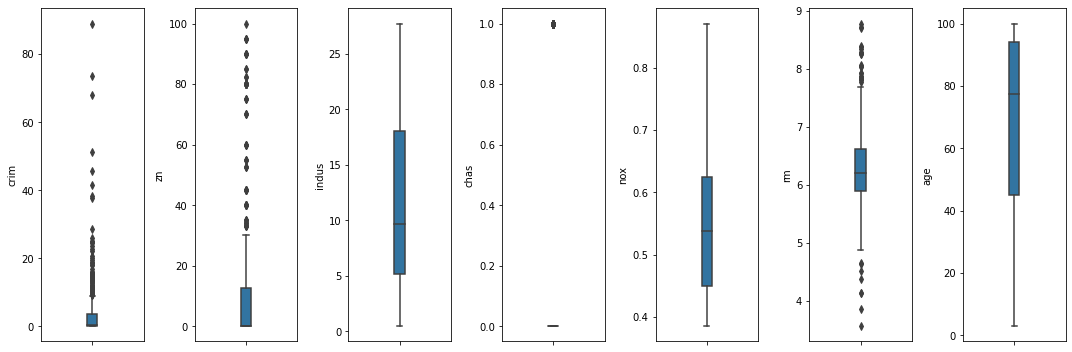

In [79]:
if not sandbox_mode:
    build_boxplots(data[numerical_cols[:partition*1]], '01')

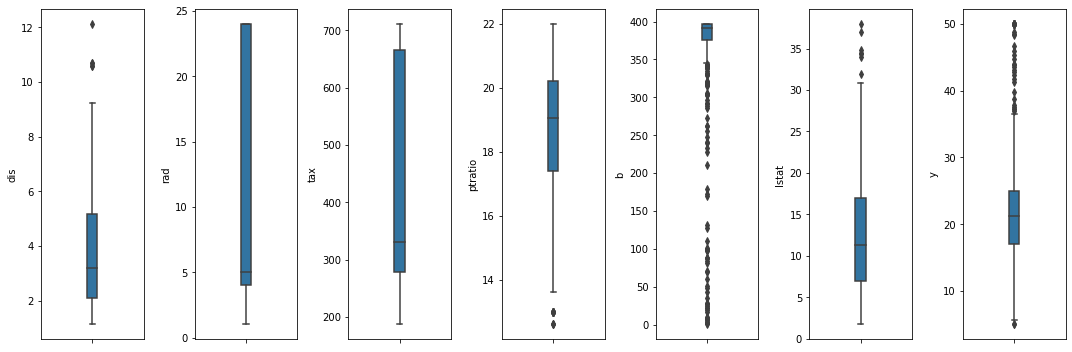

In [80]:
if not sandbox_mode:
    build_boxplots(data[numerical_cols[partition*1:partition*2]], '02')

# save data

In [81]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,y
id,,,,,,,,,,,,,,
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [82]:
data.to_csv(os.path.join(outputs, 'data.csv'))